## Import

In [1]:
pip install surprise

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

## Loading Dataset (movies_metadata, credits, ratings_small)

In [3]:
df_mov = pd.read_csv("D:\@ML\Datasets\TMDB_dataset\movies_metadata.csv", low_memory = False)

In [4]:
df_cred = pd.read_csv("D:\@ML\Datasets\TMDB_dataset\credits.csv", low_memory = False)

In [5]:
ratings = pd.read_csv(r"D:\@ML\Datasets\TMDB_dataset\ratings_small.csv")

### Data Cleaning and Stats

In [6]:
df_mov.drop_duplicates(inplace=True)

In [7]:
df_mov['id'].replace([np.inf, -np.inf], np.nan, inplace = True)

In [8]:
df_mov = df_mov.dropna(subset = ['id'])

In [9]:
df_mov.reset_index(drop = True, inplace = True)

In [10]:
# converting each row of 'id' to float and then to int, and if there is any error then drop the column
# taking too much time find a better way


for i in range(len(df_mov)):
    try:
        df_mov['id'][i] = int(float(df_mov['id'][i]))
    except:
        df_mov.drop([i], axis = 0, inplace = True)

C:\Users\soitb\AppData\Local\Temp\ipykernel_21816\2273055996.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mov['id'][i] = int(float(df_mov['id'][i]))
C:\Users\soitb\AppData\Local\Temp\ipykernel_21816\2273055996.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mov['id'][i] = int(float(df_mov['id'][i]))
C:\Users\soitb\AppData\Local\Temp\ipykernel_21816\2273055996.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mov['

In [11]:
df_mov['id'] = df_mov['id'].astype(int)

In [12]:
df_cred["id"].nunique()

45432

In [13]:
df_mov["id"].nunique()

45433

#### Concating the movies dataset

In [14]:
df_movie = df_cred.merge(df_mov, how = "left",on = "id")

In [15]:
df_movie.columns

Index(['cast', 'crew', 'id', 'adult', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [16]:
df_movie

,cast,crew,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,tt6209470,fa,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45498,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt2028550,tl,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45499,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0303758,en,...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45500,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506,False,NaN,0,[],NaN,tt0008536,en,...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


#### Basic stats of data

In [17]:
df_movie['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [18]:
df_movie['release_date'] = df_movie['release_date'].astype('datetime64[ns]')
#df_movie['release_date'] = pd.to_datetime(df_movie['release_date'], format = '%Y-%m-%d')

In [19]:
df_movie[['popularity','budget']] = df_movie[['popularity','budget']].astype(float)

In [20]:
df_movie.describe()

,id,budget,popularity,revenue,runtime,vote_average,vote_count
count,45502.000000,4.550200e+04,45499.000000,4.549900e+04,45242.000000,45499.000000,45499.000000
mean,108313.883038,4.226582e+06,2.922089,1.120738e+07,94.123978,5.618392,109.845425
std,112424.735997,1.742022e+07,6.003700,6.430694e+07,38.406211,1.923984,491.106752
min,2.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,26422.750000,0.000000e+00,0.386305,0.000000e+00,85.000000,5.000000,3.000000
50%,59999.000000,0.000000e+00,1.128317,0.000000e+00,95.000000,6.000000,10.000000
75%,157177.000000,0.000000e+00,3.681917,0.000000e+00,107.000000,6.800000,34.000000
max,469172.000000,3.800000e+08,547.488298,2.787965e+09,1256.000000,10.000000,14075.000000


In [21]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45502 entries, 0 to 45501
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cast                   45502 non-null  object        
 1   crew                   45502 non-null  object        
 2   id                     45502 non-null  int64         
 3   adult                  45502 non-null  object        
 4   belongs_to_collection  4498 non-null   object        
 5   budget                 45502 non-null  float64       
 6   genres                 45502 non-null  object        
 7   homepage               7788 non-null   object        
 8   imdb_id                45485 non-null  object        
 9   original_language      45491 non-null  object        
 10  original_title         45502 non-null  object        
 11  overview               44548 non-null  object        
 12  popularity             45499 non-null  float64       
 13  p

In [22]:
df_movie['budget'][df_movie['budget']>1].count()

8885

<Axes: xlabel='vote_average', ylabel='Count'>

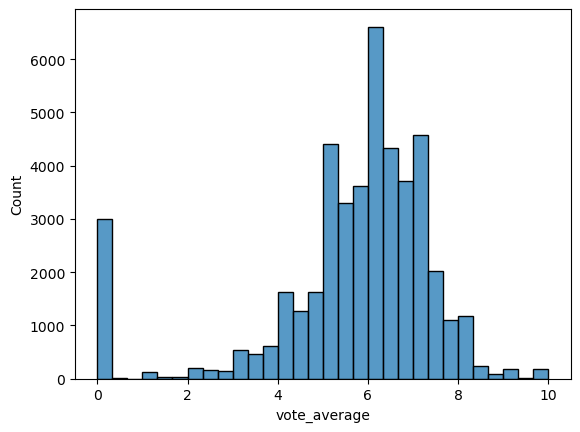

In [23]:
sns.histplot(df_movie['vote_average'], bins = 30)

In [24]:
#sns.histplot(df_movie['vote_count'][df_movie['vote_count']>2000], bins = 10)

In [25]:
df_movie['vote_count'].describe()

count    45499.000000
mean       109.845425
std        491.106752
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [27]:
m=100

In [28]:
filter_movie = df_mov[df_mov['vote_count']>m]
filter_movie.shape

(6017, 24)

## Demographic Filtering

### Weighted rating

Formula from IMDB ratings system:

WR = v/(v+m).R + m/(v+m).C

v   is the number of votes for the movie

m   is the minimum votes required to be listed in the chart

R   is the average rating of the movie

C   is the mean vote across the whole report


In [29]:
C= df_movie['vote_average'].mean()
C

5.618391613002483

In [30]:
m= df_movie['vote_count'].quantile(0.90)
m
# 90% of data is less than 160 review counts

160.0

In [31]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [32]:
filter_movie['score'] = filter_movie.apply(weighted_rating, axis=1)

C:\Users\soitb\AppData\Local\Temp\ipykernel_21816\2551920373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_movie['score'] = filter_movie.apply(weighted_rating, axis=1)


In [33]:
# Demographic filtering based on score calculated from IMDB weighted formula

In [34]:
# Ratings based on calculated "score  "
filter_movie[['title', 'vote_count', 'vote_average', 'score']].sort_values(by = 'score', ascending = False).head(20)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445873
834,The Godfather,6024.0,8.5,8.425444
10306,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421489
12478,The Dark Knight,12269.0,8.3,8.265479
2842,Fight Club,9678.0,8.3,8.256388
292,Pulp Fiction,8670.0,8.3,8.251409
522,Schindler's List,4436.0,8.3,8.206645
23664,Whiplash,4376.0,8.3,8.205411
5480,Spirited Away,3968.0,8.3,8.196062
2210,Life Is Beautiful,3643.0,8.3,8.187179


In [35]:
# popularity wise filtering of movies

In [36]:
filter_movie[['title','popularity', 'vote_count', 'vote_average', 'score']].sort_values(by = 'popularity', ascending = False).head(20)

,title,popularity,vote_count,vote_average,score
536,Blade Runner,96.272374,3833.0,7.9,7.808576
3492,Dinosaur,9.998415,563.0,6.2,6.071290
10514,Jarhead,9.997032,776.0,6.6,6.432204
11249,The Last Kiss,9.996541,125.0,5.9,5.741904
18024,Dream House,9.995617,401.0,5.8,5.748204
1360,Hamlet,9.994088,118.0,7.3,6.332168
12050,"4 Months, 3 Weeks and 2 Days",9.990406,158.0,7.4,6.503593
25384,Black Sea,9.989679,410.0,6.2,6.036742
5213,Hollywood Ending,9.987317,114.0,6.4,5.943586
4293,Cries and Whispers,9.983092,118.0,7.8,6.544398


## Content Based Filtering

In [37]:
df_movie['overview'][0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [38]:
df_movie['overview'][2]

"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max."

In [39]:
df_movie['overview'] = df_movie['overview'].fillna('')

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
# initializing the TfidfVectorizer with settings to remove stop words from the input.

tfidf = TfidfVectorizer(stop_words='english')

In [42]:
# fitting and transforming the data

matrix = tfidf.fit_transform(df_movie['overview'])


# the output values in 'matrix' is between 0 and 1

In [43]:
from sklearn.metrics.pairwise import linear_kernel

In [44]:
# computing cosine similarity between each movie to all other movies
cosine_sim = linear_kernel(matrix, matrix)

In [45]:
# Check if cosine_similarity and linear_kernal is giving same output for the tfidfvectorizer matrix------------?????????????????????????????????

#cosine_sim_tfidf = cosine_similarity(matrix[0:], matrix[0:])
#cosine_sim_tfidf

In [46]:
df_movie[['title','overview']]

,title,overview
0,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,Jumanji,When siblings Judy and Peter discover an encha...
2,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...
...,...,...
45497,Subdue,Rising and falling between a man and woman.
45498,Century of Birthing,An artist struggles to finish his work while a...
45499,Betrayal,"When one of her hits goes wrong, a professiona..."
45500,Satan Triumphant,"In a small town live two brothers, one a minis..."


In [47]:
indices = pd.Series(df_movie.index, index=df_movie['title']).drop_duplicates()

In [48]:
indices

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Waiting to Exhale                  3
Father of the Bride Part II        4
                               ...  
Subdue                         45497
Century of Birthing            45498
Betrayal                       45499
Satan Triumphant               45500
Queerama                       45501
Length: 45502, dtype: int64

In [49]:
# list of tuple [(index of the movie being compared, score)]

def recommendations(movie, n, cosine_sim=cosine_sim):
    movie_index = indices[movie]
    
    # calculating the matrix of similarity score got from comparing given movie to all other movies
    sim_score = cosine_sim[movie_index]
    
    # list of tuple of movies index and their respective similarity score
    sim_list = list(zip(list(range(len(sim_score))),sim_score))
    # above line can be achieved by list(enumerate(sim_score))
    
    # sorting based on descending (Highest to lowest) similarity score
    sim_list.sort(key = lambda x: x[1], reverse = True)
    
    # Picking top 10 scores
    # n is number of top similar movies to show
    sim_list = sim_list[1:n]
    
    # getting the list of indices of top 10 similar movies
    sim_mov_ind = [i[0] for i in sim_list]
    
    # getting the list of score of top 10 similar movies
    sim_mov_score = [i[1] for i in sim_list]
    
    # Making a new dataframe containing title of the movie
    df = df_movie['title'].iloc[sim_mov_ind].reset_index()
    
    # adding a new column named 'score' to dataframe
    df['score'] = sim_mov_score
    
    return df

In [50]:
recommendations('Toy Story',10)

,index,title,score
0,15363,Toy Story 3,0.531964
1,3000,Toy Story 2,0.472059
2,10311,The 40 Year Old Virgin,0.275073
3,24542,Small Fry,0.273084
4,23862,Andy Hardy's Blonde Trouble,0.235562
5,29236,Hot Splash,0.223858
6,43461,Andy Kaufman Plays Carnegie Hall,0.217707
7,38511,Superstar: The Life and Times of Andy Warhol,0.215973
8,42756,Andy Peters: Exclamation Mark Question Point,0.201995


In [51]:
df_movie.columns

Index(['cast', 'crew', 'id', 'adult', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [52]:
from ast import literal_eval

In [53]:
# changing the strig to list of dictionary using literal_eval() function

for i in ['cast', 'crew','genres']:
    df_movie[i] = df_movie[i].apply(literal_eval)

In [54]:
df_movie[['cast', 'crew','genres']].head()

,cast,crew,genres
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 35, 'name': 'Comedy'}]"


In [55]:
#df_movie['crew'][12495][4]['job']

In [56]:
#df_movie['cast'][12495][0]['name']

In [57]:
# get the director name for one row (perticular movie)
# x here is the list of dictionary containing crew information for a movie

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [58]:
get_director(df_movie['crew'][12495])

'Christopher Nolan'

In [59]:
# [i['name'] for i in df_movie['cast'][12495][0:3]]

In [60]:
# for y in range(2):
#     print([i['name'] for i in df_movie['cast'][y][0:3]])

In [61]:
# [i['name'] for i in df_movie['genres'][12495][0:3]]

In [62]:
# get the list of 3 elements from genres and cast for a movie

def listoftop3(x):
    name = []
    if len(x)>=3:
        for i in range(3):
            name.append(x[i]['name'])
    if len(x)<3:
        for i in range(len(x)):
            name.append(x[i]['name'])
    # can be done in one line by -->
    # name = [i['name'] for i in x]
    return name


In [63]:
#x = []
#isinstance(x,list)
#[i['name'] for i in x]

In [64]:
listoftop3(df_movie['cast'][12495])

['Christian Bale', 'Michael Caine', 'Heath Ledger']

In [65]:
# compute the director column from get_director function

df_movie['director'] = df_movie['crew'].apply(get_director)

In [66]:
# computing the top 3 cast and genres column from listoftop3 function

features = ['cast', 'genres']
for i in features:
    y = i + '_Top3'
    df_movie[y] = df_movie[i].apply(listoftop3)

In [67]:
df_movie.columns

Index(['cast', 'crew', 'id', 'adult', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'director', 'cast_Top3', 'genres_Top3'],
      dtype='object')

In [68]:
df_movie[['title', 'director', 'cast_Top3', 'genres_Top3']].head(5)

,title,director,cast_Top3,genres_Top3
0,Toy Story,John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles]","[Animation, Comedy, Family]"
1,Jumanji,Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,Howard Deutch,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[Romance, Comedy]"
3,Waiting to Exhale,Forest Whitaker,"[Whitney Houston, Angela Bassett, Loretta Devine]","[Comedy, Drama, Romance]"
4,Father of the Bride Part II,Charles Shyer,"[Steve Martin, Diane Keaton, Martin Short]",[Comedy]


In [69]:
# cleaning data of spaces

def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [70]:
# Applying clean_data function to your features.

features = ['cast_Top3', 'director', 'genres_Top3']

for feature in features:
    df_movie[feature] = df_movie[feature].apply(clean_data)

In [71]:
# now we will put all the data (cast, director and genres) in one string and make a new column name soup

# join all the data from these 3 columns seperated by space using string concatenation using join function
## Join method takes all items from iterable and joins them and seperate them based on seperator

def create_soup(x):
    return ' '.join(x['cast_Top3']) + ' ' + x['director'] + ' ' + ' '.join(x['genres_Top3'])

In [72]:
# applying join and creating soup coloumn 

df_movie['soup'] = df_movie.apply(create_soup, axis=1)

In [73]:
# Using Bag of word approach to vectorize the soup column

# not using tfidf bcz tfidf will tfidf will downweight the words based on their frequency and
# and so if a person is in multiple movies then the tfidf will penalize the importance of that person
# and kind of treat it as stopwords are treatedv (as in formula, log term will penalize the word count)


In [74]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_movie['soup'])

In [75]:
# CountVectorizer was giving int values as it is just count of words and not the frequency (in tfidf)
count_matrix[0][0]

<1x64212 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [76]:
# tfidfvectorizer was giving float values as the tfidf gives values between 0 and 1
matrix[0][0]

<1x75827 sparse matrix of type '<class 'numpy.float64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [77]:
from sklearn.metrics.pairwise import cosine_similarity

In [78]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [79]:
cosine_sim2

array([[1.        , 0.14285714, 0.14285714, ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14285714, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [80]:
#cosine_sim_test = linear_kernel(count_matrix, count_matrix)

#cosine_sim_test.shape

In [81]:
#del cosine_sim_test

In [82]:
# how to check how much ram this jupyter notebook is taking ------------------?????????????????????????????????

In [83]:
# What is the difference between sklearn.metrics.pairwise.cosine_similarity and sklearn.metrics.pairwise.linear_kernel
    # linear_kernal does not normalise the values, though cosine_smilarity normalizes the values

# How to noprmalize the linear_kernal output -------------------------------?????????????????????????????????????
    
# tfidfvectoriser vs count_vectorizer
    # count_vectorizer does not normalise the values as it is just the number of counts of words, though tfidfvectoriser normalizes the values as it is a frequency so (between 0 and 1)

# How to noprmalize the count_vectorizer output ---------------------------------????????????????????????????????????

# cosine_similarity is giving values between 0 nad 1
# linear_kernel is is giving values in integer form (greater than 1), so this is not normalized between 0 and 1


In [84]:
indices = pd.Series(df_movie.index, index=df_movie['title'])

In [85]:
recommendations('The Dark Knight Rises', 20, cosine_sim2)

,index,title,score
0,10132,Batman Begins,0.857143
1,12495,The Dark Knight,0.857143
2,516,Romeo Is Bleeding,0.571429
3,9238,Shiner,0.571429
4,11367,The Prestige,0.571429
5,23914,Quicksand,0.571429
6,24855,Deadfall,0.571429
7,9796,Amongst Friends,0.507093
8,276,Murder in the First,0.462910
9,5785,Escape to Victory,0.462910


## Colaborative Filtering

In [86]:
# For more user personalised and biased recommendations

In [87]:
df_movie.columns

Index(['cast', 'crew', 'id', 'adult', 'belongs_to_collection', 'budget',
       'genres', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'director', 'cast_Top3', 'genres_Top3',
       'soup'],
      dtype='object')

In [88]:
# We need to have the utility matrix (M*N) M users and N movies

# use pivot table to create matrix from the dataset

In [89]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [90]:
ratings = pd.read_csv(r"D:\@ML\Datasets\TMDB_dataset\ratings_small.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [91]:
# reader class of surprise library to read the file or dataframe
reader = Reader()

In [92]:
# https://surprise.readthedocs.io/en/stable/dataset.html
# Dataset class returns a Dataset object
# only takes argument in order of user id, item id and ratings

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [93]:
data

In [94]:
algo = SVD()

In [95]:
# to use 5 fold cross validation on data on 'RMSE'  and 'MAE'

cross_validate(algo, data, measures = ['RMSE','MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8949  0.9018  0.8958  0.8952  0.8919  0.8959  0.0032  
MAE (testset)     0.6879  0.6922  0.6900  0.6905  0.6880  0.6897  0.0016  
Fit time          1.45    1.39    1.17    1.37    1.83    1.44    0.22    
Test time         3.56    0.16    0.14    0.19    0.39    0.89    1.34    


{'test_rmse': array([0.89492004, 0.90177142, 0.89578127, 0.89524686, 0.89190111]),
 'test_mae': array([0.68792677, 0.69221346, 0.69000834, 0.69045358, 0.68803199]),
 'fit_time': (1.4502780437469482,
  1.38800048828125,
  1.1729998588562012,
  1.372988224029541,
  1.8339991569519043),
 'test_time': (3.561997175216675,
  0.15799951553344727,
  0.13601183891296387,
  0.18800997734069824,
  0.39200329780578613)}

In [96]:
algo.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.6292917213400733, details={'was_impossible': False})

In [97]:
trainset = data.build_full_trainset()

In [98]:
algo.fit(trainset)

In [99]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [100]:
# since user 1 have not given any ratings to movies apart from in above list
# lets predict the ratings for movie id 302 since user has not rated this one


algo.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.6764160534325336, details={'was_impossible': False})